In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from tfg_tools import *

%load_ext autoreload
%autoreload 2

C:\Users\ywen2\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Para que sea más sencillo nombrar las variables, vamos a definir dos modelos, añadiremos rev2 para diferenciarlos de los modelos de la revisión 1:
- **Modelo 1 rev2**: eliminamos las variables Blood Glucose y Glycated-HB
- **Modelo 2 rev2**: eliminamos también Vitamin-D, HOMA, Insulin

# 1. PREPROCESADO:

- **Cargamos las matrices anteriormente creadas** y que fueron divididas en train y test. Cargamos tanto los pacientes con sus variables y revisiones como las etiquetas asociadas a cada paciente

In [2]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

- Cargamos las probabilidades de pertenecer a cada clase para imputarlas como nueva columna a la revisión 2.

In [3]:
"""
Prob_train_without_BG_HB = np.load('Prob_train_review_1_all_features.npy')
Prob_test_without_BG_HB = np.load('Prob_test_review_1_all_features.npy')
Prob_train_1_without_BG_HB_VD_Ins_HOMA = np.load('Prob_train_review_1_without_homa_vit_d.npy')
Prob_test_1_without_BG_HB_VD_Ins_HOMA = np.load('Prob_test_review_1_without_homa_vit_d.npy')
"""
Prob_train_without_BG_HB = np.load('Dec_train_review_1_all_features.npy')
Prob_test_without_BG_HB = np.load('Dec_test_review_1_all_features.npy')
Prob_train_1_without_BG_HB_VD_Ins_HOMA = np.load('Dec_train_review_1_without_homa_vit_d.npy')
Prob_test_1_without_BG_HB_VD_Ins_HOMA = np.load('Dec_test_review_1_without_homa_vit_d.npy')


Prob_train_without_BG_HB_rev2 = np.load('Dec_train_review_2_all_features.npy')
Prob_test_without_BG_HB_rev2 = np.load('Dec_test_review_2_all_features.npy')
Prob_train_1_without_BG_HB_VD_Ins_HOMA_rev2 = np.load('Dec_train_review_2_without_homa_vit_d.npy')
Prob_test_1_without_BG_HB_VD_Ins_HOMA_rev2 = np.load('Dec_test_review_2_without_homa_vit_d.npy')


- **Comprobamos las dimensiones de cada matriz**, tenemos 1317 pacientes para train y 330 para test (partición 80/20).

El 13 hace referencia al número de revisiones que nosotros mismos decicimos como idóneas. 22 son el número de features.

In [4]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

print(Prob_train_without_BG_HB.shape)  
print(Prob_test_without_BG_HB.shape)
print(Prob_train_1_without_BG_HB_VD_Ins_HOMA.shape)
print(Prob_test_1_without_BG_HB_VD_Ins_HOMA.shape)

print(Prob_train_without_BG_HB_rev2.shape)  
print(Prob_test_without_BG_HB_rev2.shape)
print(Prob_train_1_without_BG_HB_VD_Ins_HOMA_rev2.shape)
print(Prob_test_1_without_BG_HB_VD_Ins_HOMA_rev2.shape)

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)
(1317,)
(330,)
(1317,)
(330,)
(1317,)
(330,)
(1317,)
(330,)


- Como observamos el el histograma, los **datos están desbalanceados**.

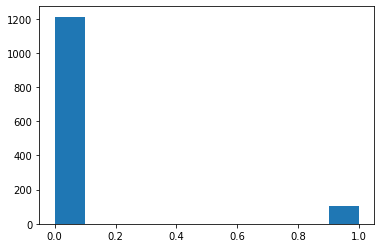

In [5]:
plt.hist(y_train)
plt.show()

In [6]:
X_train_3 = X_train[:,2,:]

Vamos a hacer lo siguiente en la función:

1. Revisar si hay alguna característica que tenga más del 50% a NaN, entonces habría que considerar eliminarla. Tenemos un problema, porque hay que revisar que tengo más de 50% en todas las revisiones. Para no complicar las cosas, vamos a considerar que trabajamos sólo con tres revisiones (vamos a ver si llegamos rápido a ese punto, en otro caso deberíamos ver si paramos en tres revisiones, que ya es bastante).

1. Revisar si hay algún paciente con más de 8 características NaN, con que esto ocurra en cualquiera de las tres revisiones, deberíamos considerarlo que se elimina, en todas las revisiones.

## 1.1 Features con problemas:

Revisando la información rápidamente hay varias features con problemas:

1. **Importante**: las variables *Blood_Glucose* y *Glycated-HB* hay que sacarlas fuera de la base de datos, porque son las que se utilizan para determinar si un pacientes diabético o no.
1. Hay cuatro variables que tiene muchos NaN, así que lo que intentaría sería centrarnos en cómo imputarlas, tanto en training como en test. Esto es un poco más complicado de lo que hacemos habitualmente con las bases de datos normales, porque aquí tenemos más datos y de forma un poco más complicada.
    * HOMA
    * Insulin
    * Vitamin-D
   
Estas son las que más tienen en las tres primeras revisiones. Lo que vamos a hacer es lo siguiente, aprovechando que tenemos un montón de datos y datos temporales vamos a utilizar un esquema diferente para hacer la imputación de forma que sea más razonable, intentando perder el menor número de datos posibles, por ejemplo: 
 * Regresión lineal múltiple con respecto a todas las variables temporales. Otra cosa
 * Verificar cuál es la correlación entre variables, para una misma revisión, y buscar con las que mayor correlación tengan y proponer un modelo de regresión lineal. 
 
Mi propuesta para el TFG: 
 * Vamos a hacer imputación por la mediana (en el caso de Vitamin-D, HOMA e Insulin) casi seguro que vamos a empeorar un poco porque hay muchos NaN, pero la esperanza es que todo se compense.
 * Si te ves con fuerzas y ganas probamos lo que he comentado anteriormente



In [7]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
df = pd.DataFrame(X_train_3,columns = feature_names[:-1])

In [8]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)

Age 112
Weight 121
Size 112
IMC 123
Creatinine 119
Cystatin 250
HDL 206
LDL 227
Triglyciredes 126
GOT 338
GPT 124
GGT 147
Albuminuria 276
Ferritin 186
HOMA 973
Insulin 960
Blood_Glucose 118
Glycated-HB 717
PCR 252
Vitamin-D 1001
TAS 109
TAD 109


Creamos una nueva variable: **X_train_imp**, obtenida de aplicar la función imputing_data a X_train. Devuelve lo siguiente

- Nº de revisión
- Features
- Features con sus respectivos NaN (no aparecen las features eliminadas previamente por la función)

In [9]:
X_train_sin_NaN_modelo1_rev3_imputing, imputed_data = imputing_data(X_train)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'PCR', 'Vitamin-D', 'TAS', 'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
PCR 231
Vitamin-D 1079
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'PCR', 'Vitamin-D', 'TAS', 'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
PCR 132
Vitamin-D 993
----------
----------
review 2
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL

- Obtenemos las **dos primeras revisiones** ya que nos es más sencillo trabajar. El resultado obtenido será extrapolable a un mayor número de revisiones.

In [10]:
#Get the second review

X_train_rev3_imputed = X_train_sin_NaN_modelo1_rev3_imputing[1]

In [11]:
newX_train_modelo1_rev3 = np.concatenate((X_train_rev3_imputed, Prob_train_without_BG_HB[:,np.newaxis]), axis=1)
print(newX_train_modelo1_rev3.shape)

(1317, 21)


In [12]:
newX_train_modelo1_rev3 = np.concatenate((newX_train_modelo1_rev3, Prob_train_without_BG_HB_rev2[:,np.newaxis]), axis=1)
print(newX_train_modelo1_rev3.shape)

(1317, 22)


### Undersampling:

Las técnicas de *undersampling* eliminan ejemplos del conjunto de datos de entrenamiento que pertenecen a la clase mayoritaria para equilibrar mejor la distribución de clases.

La técnica de submuestreo más simple implica la selección aleatoria de ejemplos de la clase mayoritaria y su eliminación del conjunto de datos de entrenamiento. Esto se conoce como submuestreo aleatorio. Aunque simple y eficaz, una limitación de esta técnica es que los ejemplos se eliminan sin preocuparse por su utilidad o importancia para determinar el límite de decisión entre las clases. Esto significa que es posible, o incluso probable, que se elimine información útil.

Una extensión de este enfoque es ser más exigente con respecto a los ejemplos de la clase mayoritaria que se eliminan. Por lo general, se trata de modelos heurísticos o de aprendizaje que intentan identificar ejemplos redundantes para la eliminación o ejemplos útiles para la no eliminación

# 2. PREDICCIÓN

### 2.1 Random Forest

Debemos probar una amplia gama de valores y ver qué funciona. Intentaremos ajustar el siguiente conjunto de hiperparámetros:

- max_features = max number of features considered for splitting a node
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

Para usar **RandomizedSearchCV**, primero necesitamos crear una cuadrícula de parámetros para muestrear durante el ajuste:

In [13]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


En cada iteración, el algoritmo elegirá una combinación diferente de las características. El beneficio de una búsqueda aleatoria es que no probamos todas las combinaciones, sino que seleccionamos al azar para muestrear una amplia gama de valores.

**Grid Search**

GridSearchCV es una clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar, puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada.

- cv, que es el número de pliegues que se deben usar para la validación cruzada. 

Más pliegues de cv reducen las posibilidades de sobreajuste, pero aumentarlo aumentará el tiempo de ejecución.

**Balanced Random Forest** es una modificación de RF, donde por cada árbol se construyen dos conjuntos bootstrap del mismo tamaño, igual al tamaño de la clase minoritaria: uno para la clase minoritaria, el otro para la clase mayoritaria. Conjuntamente, estos dos conjuntos constituyen el conjunto de entrenamiento.

In [14]:
# First create the base model to tune

#Creo que es mejor la estrategia que se presenta en from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf_1 = BalancedRandomForestClassifier(n_estimators=30, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [15]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_1, random_grid, cv=7 , n_jobs = -1, verbose = 3)

In [16]:
# Fit the random search model
grid_random.fit(newX_train_modelo1_rev3, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=30),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [17]:
grid_random.best_params_

{'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

Creamos un **nuevo modelo** teniendo en cuenta los hiperparámetros que nos devuelve Grid_Search

In [18]:
rf_2 = BalancedRandomForestClassifier(n_estimators=1000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample',n_jobs=-1,verbose = 3)

In [19]:
rf_2.fit(newX_train_modelo1_rev3, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 1 of 1000
building tree 5 of 1000building tree 6 of 1000

building tree 7 of 1000
building tree 8 of 1000
building tree 10 of 1000
building tree 9 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 14 of 1000building tree 13 of 1000

building tree 16 of 1000
building tree 15 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000building tree 20 of 1000

building tree 21 of 1000
building tree 23 of 1000
building tree 22 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000building tree 30 of 1000

building tree 31 of 1000
building tree 32 of 1000


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 34 of 1000
building tree 33 of 1000
building tree 35 of 1000
building tree 36 of 1000building tree 37 of 1000

building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 45 of 1000
building tree 44 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 51 of 1000
building tree 49 of 1000building tree 50 of 1000

building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000building tree 59 of 1000

building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 65 of 1000
building tree 64 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 72 of 1000
building tree 73 of 1000


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.2s


building tree 134 of 1000
building tree 133 of 1000
building tree 135 of 1000
building tree 136 of 1000building tree 137 of 1000

building tree 138 of 1000
building tree 139 of 1000
building tree 142 of 1000
building tree 141 of 1000
building tree 140 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 146 of 1000
building tree 145 of 1000
building tree 149 of 1000
building tree 148 of 1000building tree 147 of 1000

building tree 150 of 1000
building tree 151 of 1000
building tree 152 of 1000
building tree 154 of 1000
building tree 153 of 1000
building tree 156 of 1000
building tree 155 of 1000
building tree 157 of 1000
building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 164 of 1000
building tree 163 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 169 of 1000
building tree 170 of 1000building tree 168 of 1000

building tre

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.6s


building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 294 of 1000
building tree 295 of 1000building tree 293 of 1000

building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000
building tree 305 of 1000
building tree 306 of 1000
building tree 307 of 1000
building tree 309 of 1000building tree 308 of 1000

building tree 310 of 1000
building tree 311 of 1000
building tree 312 of 1000
building tree 313 of 1000
building tree 314 of 1000
building tree 315 of 1000
building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000
building tree 319 of 1000
building tree 321 of 1000building tree 320 of 1000

building tree 322 of 1000
building tree 323 of 1000
building tree 325 of 1000building tree 326 of 1000

building tree 324 of 1000
building tree 327 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.5s


building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000building tree 533 of 1000

building tree 534 of 1000
building tree 535 of 1000
building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000
building tree 540 of 1000
building tree 541 of 1000
building tree 542 of 1000
building tree 543 of 1000
building tree 544 of 1000
building tree 545 of 1000
building tree 546 of 1000
building tree 547 of 1000building tree 548 of 1000

building tree 549 of 1000
building tree 550 of 1000
building tree 551 of 1000
building tree 552 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    7.0s



building tree 817 of 1000building tree 816 of 1000

building tree 818 of 1000
building tree 819 of 1000
building tree 821 of 1000
building tree 820 of 1000
building tree 822 of 1000
building tree 823 of 1000
building tree 824 of 1000
building tree 825 of 1000
building tree 826 of 1000
building tree 827 of 1000
building tree 828 of 1000
building tree 829 of 1000
building tree 830 of 1000
building tree 832 of 1000
building tree 831 of 1000
building tree 833 of 1000
building tree 834 of 1000
building tree 835 of 1000
building tree 836 of 1000
building tree 838 of 1000building tree 837 of 1000

building tree 839 of 1000
building tree 840 of 1000
building tree 841 of 1000building tree 842 of 1000

building tree 844 of 1000
building tree 843 of 1000
building tree 845 of 1000
building tree 846 of 1000
building tree 847 of 1000
building tree 848 of 1000
building tree 849 of 1000
building tree 850 of 1000
building tree 851 of 1000
building tree 852 of 1000
building tree 853 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.8s finished


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='log2', n_estimators=1000,
                               n_jobs=-1, verbose=3)

In [20]:
y_pred_modelo1_rev3 = rf_2.predict(newX_train_modelo1_rev3)
print(y_pred_modelo1_rev3)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s


[0 1 0 ... 1 0 0]


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


In [21]:
y_pred_prob_modelo1_rev3 = rf_2.predict_proba(newX_train_modelo1_rev3)
print(y_pred_prob_modelo1_rev3)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s


[[0.96  0.04 ]
 [0.111 0.889]
 [0.902 0.098]
 ...
 [0.336 0.664]
 [0.923 0.077]
 [0.914 0.086]]


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.5s finished


## 2.2 Prestaciones

La **sensibilidad y la especificidad** son dos valores que nos indican la capacidad de nuestro estimador para discriminar los casos positivos, de los negativos. La sensibilidad es la fracción de verdaderos positivos, mientras que la especificidad, es la fracción de verdaderos negativos.

-  **La sensibilidad** es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.
-  **La especificidad** se trata de los casos negativos que el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase.
- **La Precisión** se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción entre el número de predicciones correctas (tanto positivas como negativas) y el total de predicciones. En forma práctica es  el porcentaje de casos positivos detectados.


### Prestaciones en train

In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


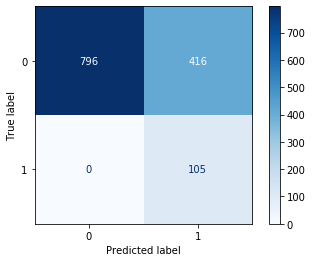

Accuracy :  0.6841305998481397
Sensitivity :  1.0
Specificity :  0.6567656765676567
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.66      1.00      0.79      0.81      0.63      1212
          1       0.20      1.00      0.66      0.34      0.81      0.68       105

avg / total       0.94      0.68      0.97      0.76      0.81      0.64      1317



In [23]:
cm = confusion_matrix(y_train,y_pred_modelo1_rev3)

plot_confusion_matrix(rf_2,newX_train_modelo1_rev3,y_train,cmap=plt.cm.Blues)

plt.show()

accuracy1=(cm[0,0]+cm[1,1])/(cm[1,0]+cm[1,1]+cm[0,0]+cm[0,1])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_train, y_pred_modelo1_rev3))

### Prestaciones en test

(330, 22)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Paral

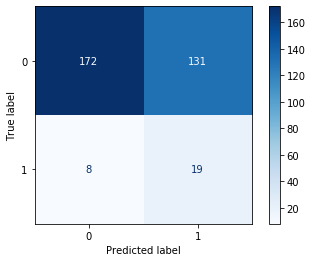

In [24]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo1_rev3 = pd.DataFrame(X_test[:,2,:],columns = feature_names[:-1])

X_test_modelo1_rev3 = X_test_modelo1_rev3.drop('Blood_Glucose',axis = 1)
X_test_modelo1_rev3 = X_test_modelo1_rev3.drop('Glycated-HB',axis = 1)

#impute

X_test_modelo1_rev3 = X_test_modelo1_rev3.fillna(imputed_data[1])
newX_test_modelo1_rev3 = np.concatenate((X_test_modelo1_rev3, Prob_test_without_BG_HB[:,np.newaxis]), axis=1)
newX_test_modelo1_rev3 = np.concatenate((newX_test_modelo1_rev3, Prob_test_without_BG_HB_rev2[:,np.newaxis]), axis=1)
print(newX_test_modelo1_rev3.shape)

y_pred_test_modelo1_rev3 = rf_2.predict(newX_test_modelo1_rev3)
y_pred_test_prob_modelo1_rev3 = rf_2.predict_proba(newX_test_modelo1_rev3)


plot_confusion_matrix(rf_2,newX_test_modelo1_rev3,y_test,cmap=plt.cm.Blues)

plt.show()

In [25]:
cm1 = confusion_matrix(y_test,y_pred_test_modelo1_rev3)

accuracy1=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
print ('Accuracy : ', accuracy1)

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)

Accuracy :  0.5787878787878787
Specificity :  0.5676567656765676
Sensitivity :  0.7037037037037037


# Aplicamos el modelo eliminando las variables Vitamin-D, HOMA e Insulin

# 1. PREPROCESADO

In [26]:
X_train_sin_NaN_modelo2_rev3_imputing,imputed_data = imputing_data(X_train,without_homa_vit_d=True)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'PCR',
       'TAS', 'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
PCR 231
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'PCR',
       'TAS', 'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
PCR 132
----------
----------
review 2
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'PCR',
       'TAS', 'TAD'],
      dtype='object')
Ag

In [27]:
#Get the second review

X_train_sin_NaN_modelo2_rev3 = X_train_sin_NaN_modelo2_rev3_imputing[1]

In [28]:
newX_train_modelo2_rev3 = np.concatenate((X_train_sin_NaN_modelo2_rev3, Prob_train_1_without_BG_HB_VD_Ins_HOMA[:,np.newaxis]), axis=1)

In [29]:
newX_train_modelo2_rev3 = np.concatenate((newX_train_modelo2_rev3, Prob_train_1_without_BG_HB_VD_Ins_HOMA_rev2[:,np.newaxis]), axis=1)

In [30]:
print(newX_train_modelo2_rev3.shape)

(1317, 19)


# 2. PREDICCIÓN

## 2.1 Random Forest

In [31]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


In [32]:
# First create the base model to tune
rf_11 = BalancedRandomForestClassifier(n_estimators=30, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [33]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_11, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [34]:
# Fit the random search model
grid_random.fit(newX_train_modelo2_rev3, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=30),
             n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=5)

In [35]:
grid_random.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

### Rebalancea dentro de cada árbol

In [36]:
rf_22 = BalancedRandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [37]:
rf_22.fit(newX_train_modelo2_rev3, y_train)

BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='sqrt', n_estimators=5000)

In [38]:
y_pred_modelo2_rev3 = rf_22.predict(newX_train_modelo2_rev3)
y_pred_1_prob_modelo2_rev3 = rf_22.predict_proba(newX_train_modelo2_rev3)

## 2.2 Calibración de la probabilidad

In [39]:
'''from sklearn.calibration import CalibratedClassifierCV

base_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

#vamos a calibrar training
calibrated_clf = CalibratedClassifierCV(base_estimator=rf_22,cv='prefit', method = 'sigmoid',ensemble = False)

calibrated_clf.fit(X_train_11, y_train)'''

"from sklearn.calibration import CalibratedClassifierCV\n\nbase_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],\n                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    \n                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')\n\n#vamos a calibrar training\ncalibrated_clf = CalibratedClassifierCV(base_estimator=rf_22,cv='prefit', method = 'sigmoid',ensemble = False)\n\ncalibrated_clf.fit(X_train_11, y_train)"

In [40]:
'''#calibrated_clf.
from sklearn.calibration import calibration_curve

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
X_test_1 = X_test_1.drop('HOMA',axis = 1)
X_test_1 = X_test_1.drop('Insulin',axis = 1)
X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)

X_test_1 = X_test_1.fillna(X_train_1.median())


y_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]

y_train_cali = calibrated_clf.predict_proba(X_train_11)[:,1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=10)
fraction_of_positives_train, mean_predicted_value_train = calibration_curve(y_train, y_train_cali, n_bins=10)

plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot(mean_predicted_value_train, fraction_of_positives_train, "^-")


plt.figure()
plt.hist(y_pred_cali, range=(0, 1), bins=10,histtype="step", lw=2)
plt.hist(y_train_cali, range=(0, 1), bins=10,histtype="step", lw=2)


plt.hist(rf_22.predict_proba(X_train_11)[:,1],bins = 10,histtype='step')'''

'#calibrated_clf.\nfrom sklearn.calibration import calibration_curve\n\nfeature_names = [\'Age\',\'Weight\',\'Size\',\'IMC\',\'Creatinine\',\'Cystatin\',\'HDL\',\'LDL\',\'Triglyciredes\',\'GOT\',\'GPT\',\'GGT\',\'Albuminuria\',\'Ferritin\',\'HOMA\',\'Insulin\',\'Blood_Glucose\',\'Glycated-HB\',\'PCR\',\'Vitamin-D\',\'TAS\',\'TAD\',\'Date\']\n\nX_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])\n\nX_test_1 = X_test_1.drop(\'Blood_Glucose\',axis = 1)\nX_test_1 = X_test_1.drop(\'Glycated-HB\',axis = 1)\nX_test_1 = X_test_1.drop(\'HOMA\',axis = 1)\nX_test_1 = X_test_1.drop(\'Insulin\',axis = 1)\nX_test_1 = X_test_1.drop(\'Vitamin-D\',axis = 1)\n\nX_test_1 = X_test_1.fillna(X_train_1.median())\n\n\ny_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]\n\ny_train_cali = calibrated_clf.predict_proba(X_train_11)[:,1]\n\nfraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=10)\nfraction_of_positives_train, mean_predicted_value_train = 

## 2.3 Prestaciones

### Prestaciones en train

In [41]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[[805 407]
 [  0 105]]


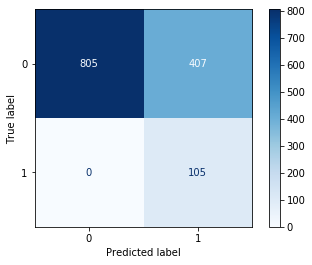

Accuracy :  0.6909643128321944
Sensitivity :  1.0
Specificity :  0.6641914191419142


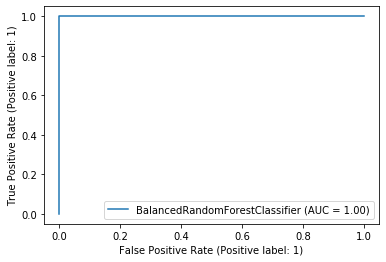

In [42]:
cm2 = confusion_matrix(y_train,y_pred_modelo2_rev3)
print(cm2)

plot_confusion_matrix(rf_22,newX_train_modelo2_rev3,y_train,cmap=plt.cm.Blues)

plt.show()

accuracy1=(cm2[0,0]+cm2[1,1])/(cm2[1,0]+cm2[1,1]+cm2[0,0]+cm2[0,1])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm2[1,1]/(cm2[1,0]+cm2[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm2[0,0]/(cm2[0,0]+cm2[0,1])
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_train_modelo2_rev3, y_train)
plt.show()

### Prestaciones en test

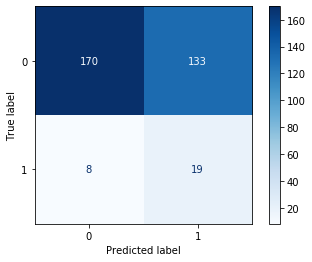

In [43]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo2_rev3 = pd.DataFrame(X_test[:,2,:],columns = feature_names[:-1])

X_test_modelo2_rev3 = X_test_modelo2_rev3.drop('Blood_Glucose',axis = 1)
X_test_modelo2_rev3 = X_test_modelo2_rev3.drop('Glycated-HB',axis = 1)
X_test_modelo2_rev3 = X_test_modelo2_rev3.drop('HOMA',axis = 1)
X_test_modelo2_rev3 = X_test_modelo2_rev3.drop('Insulin',axis = 1)
X_test_modelo2_rev3 = X_test_modelo2_rev3.drop('Vitamin-D',axis = 1)

#impute

X_test_modelo2_rev3 = X_test_modelo2_rev3.fillna(imputed_data[1])
newX_test_modelo2_rev3 = np.concatenate((X_test_modelo2_rev3, Prob_test_1_without_BG_HB_VD_Ins_HOMA[:,np.newaxis]), axis=1)
newX_test_modelo2_rev3 = np.concatenate((newX_test_modelo2_rev3, Prob_test_1_without_BG_HB_VD_Ins_HOMA_rev2[:,np.newaxis]), axis=1)


y_pred_test_modelo2_rev3 = rf_22.predict(newX_test_modelo2_rev3)
y_pred_test_prob_modelo2_rev3 = rf_22.predict_proba(newX_test_modelo2_rev3) #Probabilidad de pertenecer a cada clase

plot_confusion_matrix(rf_22,newX_test_modelo2_rev3,y_test,cmap=plt.cm.Blues)

plt.show()

[[170 133]
 [  8  19]]
Accuracy :  0.5727272727272728
Specificity :  0.5610561056105611
Sensitivity :  0.7037037037037037


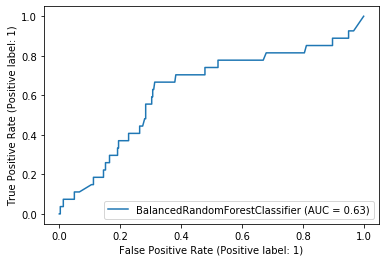

In [44]:
cm3 = confusion_matrix(y_test,y_pred_test_modelo2_rev3)
print(cm3)

accuracy1=(cm3[0,0]+cm3[1,1])/(cm3[1,0]+cm3[1,1]+cm3[0,0]+cm3[0,1])
print ('Accuracy : ', accuracy1)

specificity1 = cm3[0,0]/(cm3[0,0]+cm3[0,1])
print('Specificity : ', specificity1)

sensitivity1 = cm3[1,1]/(cm3[1,0]+cm3[1,1])
print('Sensitivity : ', sensitivity1 )

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_test_modelo2_rev3, y_test)
plt.show()